In [ ]:
import tensorflow as tf

For Torch, check if a GPU is available, else opt for a CPU instead

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")

    print('No. of GPUs found: %d' % torch.cuda.device_count())
    print('GPU selected:', torch.cuda.get_device_name(0))

else:
    print('No GPU found, using the CPU instead')
    device = torch.device("cpu")

No. of GPUs found: 1
GPU selected: Tesla T4


In [ ]:
!pip install transformers
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=f7e023f5edcd3d824b6e5f3042aba22f4cb88ed16645f23924c67c2f8944e4f6
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import wget
import os

print('Setting up the Corpus of Linguistic Acceptability (CoLA) dataset')
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

Setting up the Corpus of Linguistic Acceptability (CoLA) dataset


In [ ]:
# Upzipping the datset
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
2352,l-93,0,*,We investigated for bombs in the area.
2501,l-93,1,NaN,Pauline hammered the metal flat.
2767,l-93,1,NaN,Michelle kept the papers under the desk.
1237,r-67,1,NaN,The proof that this set is recursive is diffic...
6222,c_13,1,NaN,Briana showed Justin himself.
2983,l-93,0,*,We spotted them run.
7203,sks13,0,*,it is the tall man coming from England that Ma...
3543,ks08,1,NaN,They read the new book.
6767,m_02,0,*,"Because never had Sir Thomas been so offended,..."
4566,ks08,0,*,The roof is leaked.


In [ ]:
#Example of 5 random unacceptable sentences
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
2620,Doug removed the scratches to nowhere.,0
6308,They want to hire someone who speaks a Balkan ...,0
3029,I hunted for game in the woods.,0
1947,I didn't eat any ice cream and any cake.,0
5282,How easy to tease John it is!,0


In [ ]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

###Tokenizing using BERT

In [ ]:
from transformers import BertTokenizer

print('Loading BERT tokenizer')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#Working of tokenizing operation:

# Display original sentence
print(' Original: ', sentences[0])

#Display sentence after being split into tokens
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Display the sentence mapped to token ids
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [ ]:
max_len = 0

# For each sentence-
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  47


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs
input_ids = []
attention_masks = []

for sent in sentences:

    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )

    # Add the encoded sentence to the list
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0 as a list of IDs
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


###Training & Validation Split

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

Using **BertForSequenceClassification** for training

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Get all of the model's parameters as a list of tuples
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

Optimizer and learning rate

In [ ]:
#AdamW is a class from the huggingface library
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

###Training

In [ ]:
import numpy as np

#Calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    #Round to the nearest second
    elapsed_rounded = int(round((elapsed)))

    #Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random
import numpy as np

seed_val = 13

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

#Measure the total training time
total_t0 = time.time()

for epoch_i in range(0, epochs):

    #Training Operations

    #Perform one full pass over the training set
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    #Measure the duration of each epoch
    t0 = time.time()

    #Reset the total loss for the epoch
    total_train_loss = 0

    model.train()

    # For each batch-
    for step, batch in enumerate(train_dataloader):

        #Give an update on progress after every 40 items
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        #Perform a forward pass to evaluate the model on the training batch
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = output.loss
        logits = output.logits

        total_train_loss += loss.item()

        #Perform a backward pass to calculate gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        #Update learning rate
        scheduler.step()

    #Calculate average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)

    #Measure the entire duration for the epoch
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    #Validation Operations

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    #Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            valid_output = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            val_loss = valid_output.loss
            val_logits = valid_output.logits

        # Accumulate validation loss
        total_eval_loss += val_loss.item()

        #Move logits and labels to CPU
        val_logits = val_logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(val_logits, label_ids)


    #Report final accuracy for this validation cycle
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    #Calculate average loss for all of the batches combined
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    #Measure the entire duration for the validation cycle
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    #Record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:14.
  Batch    80  of    241.    Elapsed: 0:00:27.
  Batch   120  of    241.    Elapsed: 0:00:40.
  Batch   160  of    241.    Elapsed: 0:00:53.
  Batch   200  of    241.    Elapsed: 0:01:07.
  Batch   240  of    241.    Elapsed: 0:01:21.

  Average training loss: 0.51
  Training epoch took: 0:01:21

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.43
  Validation took: 0:00:03

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:14.
  Batch    80  of    241.    Elapsed: 0:00:27.
  Batch   120  of    241.    Elapsed: 0:00:40.
  Batch   160  of    241.    Elapsed: 0:00:54.
  Batch   200  of    241.    Elapsed: 0:01:07.
  Batch   240  of    241.    Elapsed: 0:01:21.

  Average training loss: 0.32
  Training epoch took: 0:01:21

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.43
  Validation took: 0:00:03

======== Epoch 3 / 3 ========
Training...
 

Training process summary

In [ ]:
import pandas as pd

pd.set_option('display.precision', 2)

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.51,0.43,0.80,0:01:21,0:00:03
2,0.32,0.43,0.84,0:01:21,0:00:03
3,0.21,0.45,0.84,0:01:21,0:00:03


Losses

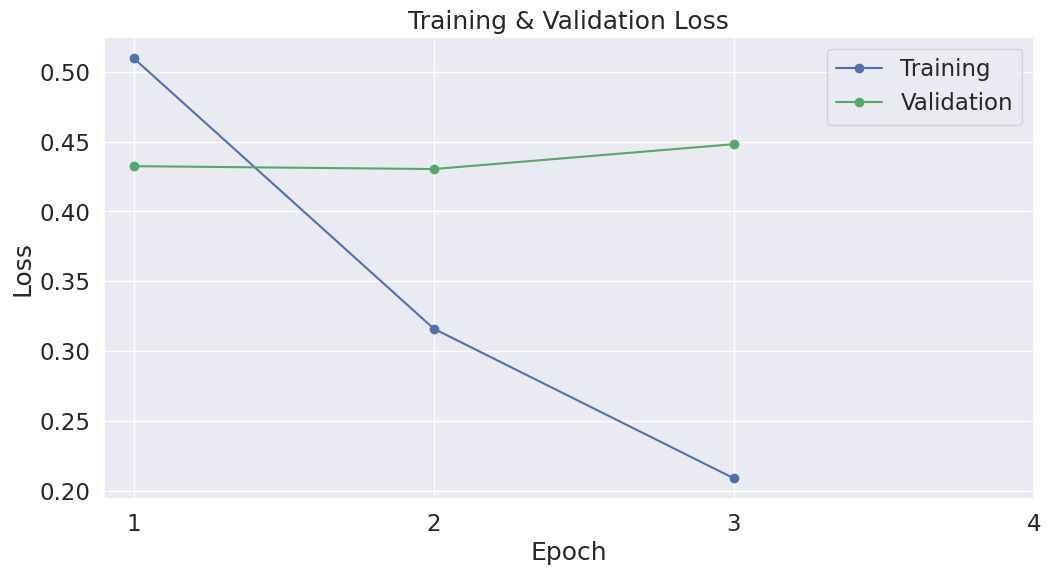

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

#Plot learning curve
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

#Create labels for the plot
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

###Test set evaluation

In [ ]:
import pandas as pd

df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

print('Number of test sentences: {:,}\n'.format(df.shape[0]))

sentences = df.sentence.values
labels = df.label.values

# Map the sentence tokens to thier word IDs
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    input_ids.append(encoded_dict['input_ids'])

    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('DONE.')

Predicting labels for 516 test sentences...
DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

#Evaluate each test batch using Matthew's correlation coefficient
print('Matthews Corr. Coef. for each batch calculated')

for i in range(len(true_labels)):

  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  #Calculate and store the coef for the batch
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

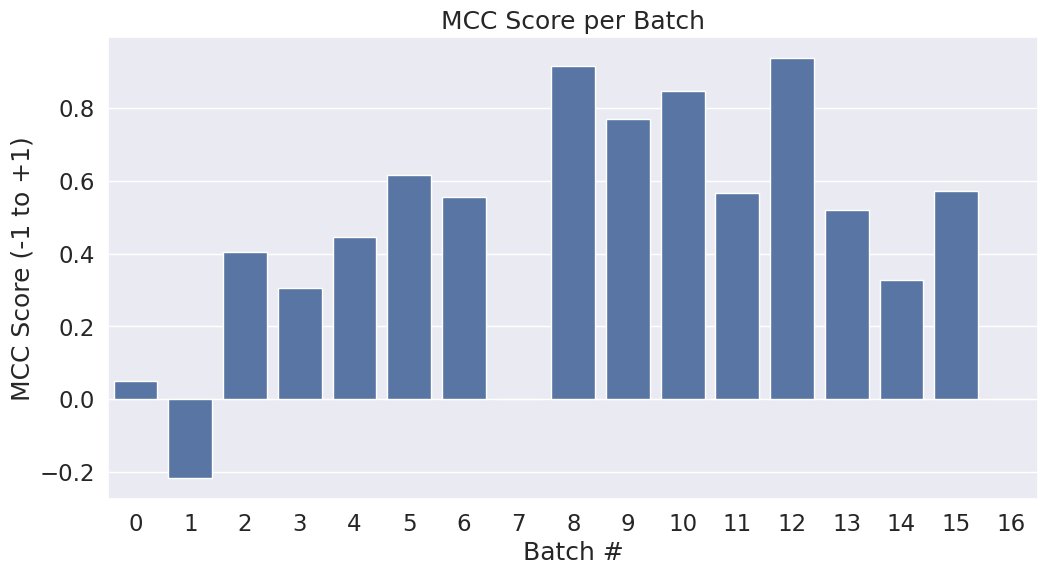

In [ ]:
#Create a barplot showing the MCC score for each batch of test samples
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
#Combine results for all batches.
flat_predictions = np.concatenate(predictions, axis=0)

#For every sample, pick the label (0 or 1) with the higher score
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

#Combine the correct labels for each batch into a single list
flat_true_labels = np.concatenate(true_labels, axis=0)

#Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.524
